<h1> Wide and Deep Networks</h1>
Authors: Sam Yao, Rebecca Kuhlman, Michael Amberg

<h2>Data Preparation</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data",
                 names=["Wife's age","Wife's education","Husband's education",
                        "Number of children","Religion","Wife's working?"
                        ,"Husband's occupation","Standard-of-living index","Media exposure", "Contraceptive method used"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Wife's age                 1473 non-null   int64
 1   Wife's education           1473 non-null   int64
 2   Husband's education        1473 non-null   int64
 3   Number of children         1473 non-null   int64
 4   Religion                   1473 non-null   int64
 5   Wife's working?            1473 non-null   int64
 6   Husband's occupation       1473 non-null   int64
 7   Standard-of-living index   1473 non-null   int64
 8   Media exposure             1473 non-null   int64
 9   Contraceptive method used  1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB
None


In [2]:
print(df.describe())

        Wife's age  Wife's education  Husband's education  Number of children  \
count  1473.000000       1473.000000          1473.000000         1473.000000   
mean     32.538357          2.958588             3.429735            3.261371   
std       8.227245          1.014994             0.816349            2.358549   
min      16.000000          1.000000             1.000000            0.000000   
25%      26.000000          2.000000             3.000000            1.000000   
50%      32.000000          3.000000             4.000000            3.000000   
75%      39.000000          4.000000             4.000000            4.000000   
max      49.000000          4.000000             4.000000           16.000000   

          Religion  Wife's working?  Husband's occupation  \
count  1473.000000      1473.000000           1473.000000   
mean      0.850645         0.749491              2.137814   
std       0.356559         0.433453              0.864857   
min       0.000000        

Attribute Information:

   1. Wife's age                     (numerical) - INT
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical) - INT
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
      -What the categories were mapped to is unknown
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
10. Contraceptive method used     (class attribute)  1=No-use
                                                        2=Long-term
                                                        3=Short-term
Contraceptive method used is our predicting variable.
We changed its sparse catagorical values to:
0 - No-use of Contraceptives (current method)
1 - Short-term Use of Contraceptives (current method)
2 - Long-term Use of Contraceptives (current method)

In [3]:
#removing Husband's Occupation

df = df.drop(labels="Husband's occupation", axis = 1)

#Cleaning to set no Contraceptive to 0, short term to 1, and long term staying at 2
df[["Contraceptive method used"]] = df[["Contraceptive method used"]].replace(1, 0)
df[["Contraceptive method used"]] = df[["Contraceptive method used"]].replace(3, 1)

<Axes: >

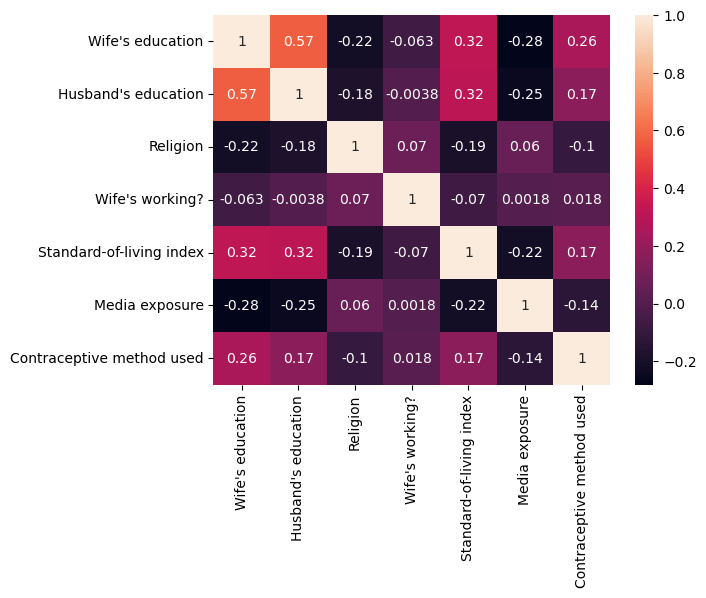

In [4]:
#print heatmap
import seaborn as sns

df_corr = df[["Wife's education",
              "Husband's education",
              "Religion",
              "Wife's working?",
              "Standard-of-living index",
              "Media exposure", 
              "Contraceptive method used"]]
sns.heatmap(df_corr.corr(method="kendall"), annot = True) #Kendall works for categorical data

From this heatmap, we can see an interesting trend. Contraceptive use has a small positive correlation with wife's education, while media exposure has a small negative correlation.

Let's see what a Random Forest Decision Tree estimator has to say.

 1) Wife's age                     0.414002
 2) Religion                       0.252535
 3) Standard-of-living index       0.090895
 4) Wife's education               0.089419
 5) Husband's education            0.070643
 6) Wife's working?                0.038719
 7) Number of children             0.027715
 8) Media exposure                 0.016071


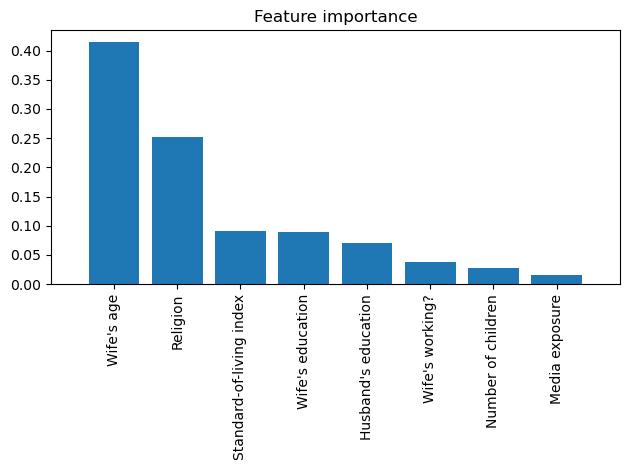

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#Code taken from textbook by Raschka
feat_labels = df.columns[:8]
rfc = RandomForestClassifier(n_estimators = 500,
                            random_state = 1)
X = df[["Wife's age","Wife's education",
               "Husband's education", "Religion","Number of children", 
               "Wife's working?","Standard-of-living index",
               "Media exposure"]]
y = df["Contraceptive method used"].values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]),
            feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
                            

Utilizing the Random Forest method for feature importance (outlined in Raschka et al. on page 134), we can see that the Wife's Age and the Religion will be the most likely to have an impact on training. 

For scaling, we went with min-max scaling. The reason is because the features we want to scale, age and number of children, have a defined 0. For example, it makes no sense to have a negative age or to have borne negative children. Since MinMax scales from 0 to 1, this will be our scaler of choice.

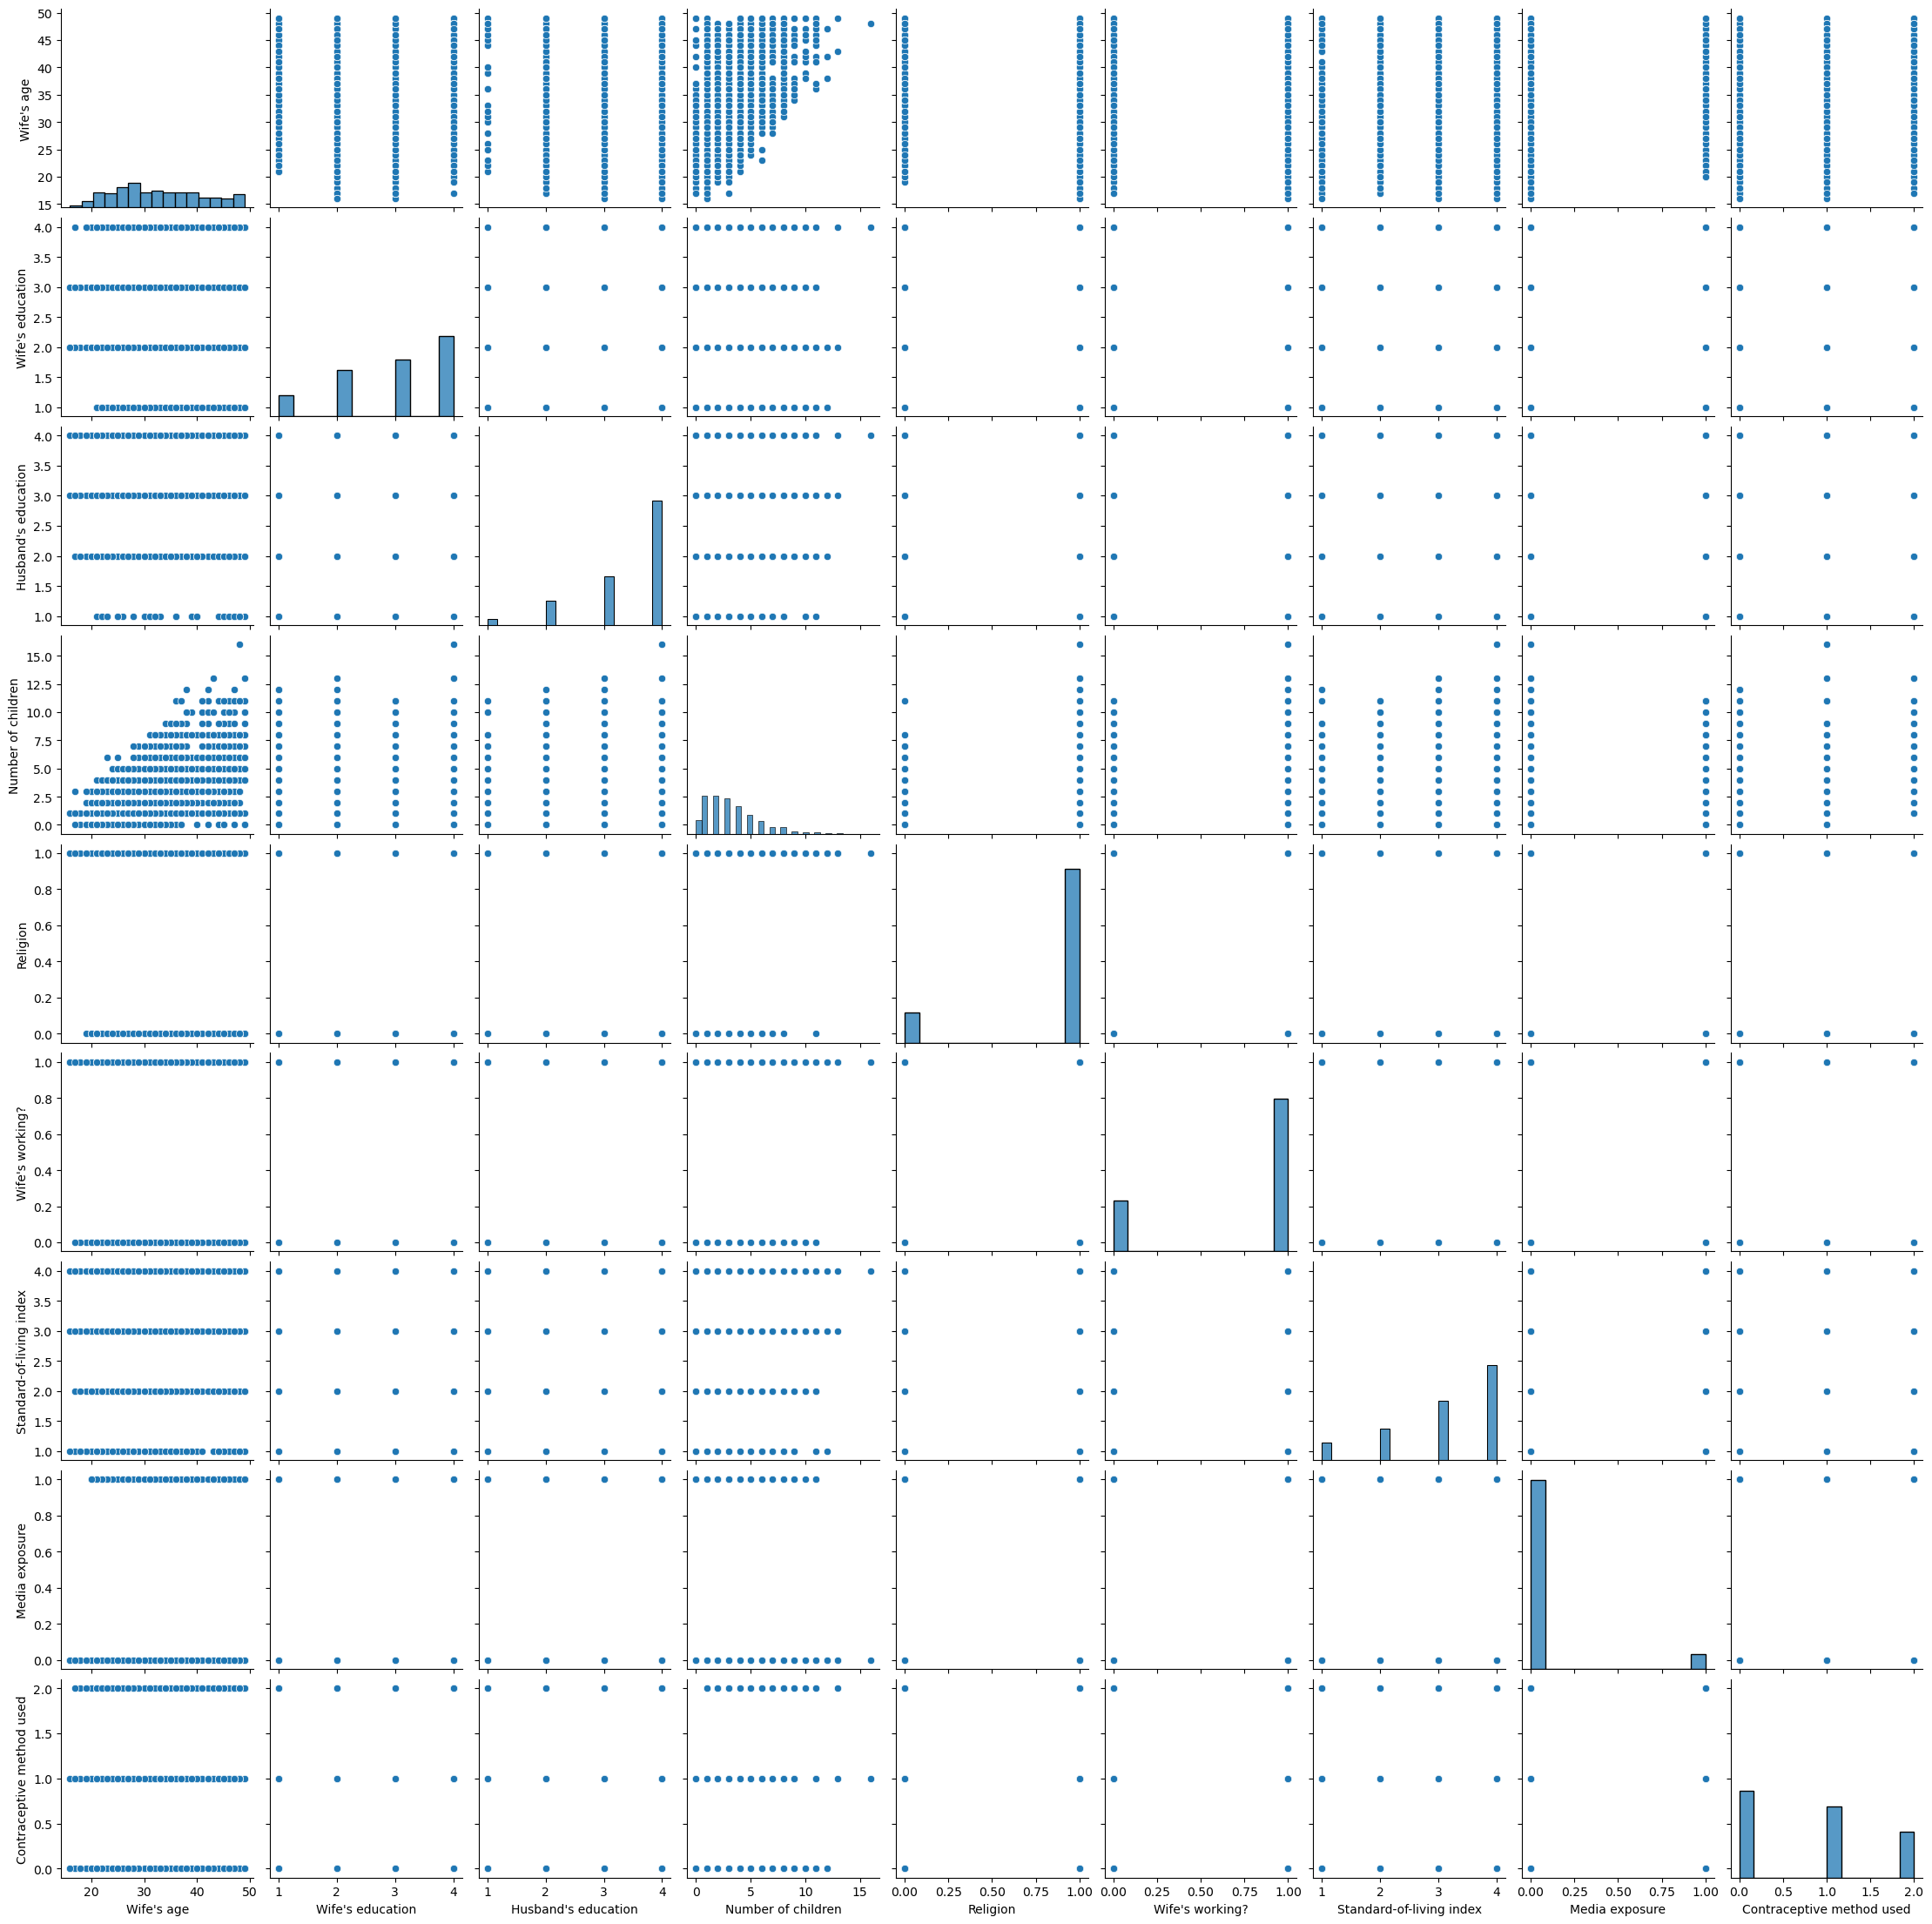

In [6]:
sns.pairplot(df)

<h3>Cross Product Features</h3>
[1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).

Wife working and wife education are related features that could be combined, but there is a lot of nuance between them. For example, education is generally linked to socio-economic class. A wife could have very high education and therefore be working a white collar job, or a wife could be poorly educated and need to work due to needing to bring in money to the household as well. We have a few enough features that is it not needed to cross product features, so due to the nuance in this case, we will test the features as is as well.

Media exposure is linked to wife's education as well, so we will also try a model where these features are crossed.

It may also be worth it to cross the attributes "Wife's Education" with "Husband's Education". There could be some sort of pattern that we could find with patterns involving different combinations of the couple's educational backgrounds.

<h3>Metrics for Algorithm Performance</h3>
[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


The most important feature prediction is no contraceptive use vs contraceptive use. We are using our prediction algorithm to determine which women we are going to give extra contraception information to. Taking contraceptive use as true, a false positive has much higher risk than a false negative. Because of this, we will choose specificity score as our metric. We want to cover all true negatives.

<h3>Dividing into Training and Testing</h3>
[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

Our data is a subset of a census of Indonesian Women, so our split relies on the good practices of whom we got the dataset from. There is slightly more women without contraceptive use than the group using short term and the group using long term. Stratified splits would make sure we are testing an equal proportion of each class, however in this case, a standard shuffled split would work most of the time.

I think that using stratified k-folds would be the move in this case. Now the exact number of folds is debateable. I plan to use 10, since studies show that it is empircally about the best. Additionally, our dataset isn't that large, with about 1500 instances, leaving about 150 instances per fold.

Begin to think of yourself as working in a team, all your choices are shaped by the other people that have domain knowledge.

If you do get good results, show graphs of that to show performance over time.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
mms = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

X_train[["Wife's age", "Number of children"]] = mms.fit_transform(X_train[["Wife's age", "Number of children"]])
X_test[["Wife's age", "Number of children"]] = mms.fit_transform(X_test[["Wife's age", "Number of children"]])

kfold = StratifiedKFold(n_splits=10).split(X_train,y_train)

In [21]:
# Function to generate the ROC curve of all the models for comparison
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from numpy import interp
from itertools import cycle
def plot_roc_curve(model, X_test, y_test):
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_score = model.predict(X_test)
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves for each class and the macro-averaged curve
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=2,
             label='Macro-average ROC curve (AUC = {0:0.2f})'
             ''.format(roc_auc["macro"]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

<h2>Modeling (5 points total)</h2>

Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly.

Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). .

In [9]:
categorical_headers = ["Wife's education",'Religion',"Wife's working?",
                       'Standard-of-living index','Media exposure']
num_headers = ["Wife's age", "Number of children"]

In [10]:
# sandbox for looking at different categorical variables
for col in categorical_headers:
    vals = X_train[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

Wife's education has 4 unique values:
[4 3 1 2]
Religion has 2 unique values:
[1 0]
Wife's working? has 2 unique values:
[1 0]
Standard-of-living index has 4 unique values:
[3 4 2 1]
Media exposure has 2 unique values:
[0 1]


In [11]:
cross_columns = [["Media exposure","Wife's education"],
                 ["Wife's working?","Wife's education"],
                 ["Religion"]]

In [12]:
import tensorflow as tf
from tensorflow import keras
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.metrics import SpecificityAtSensitivity
speci_score = tf.keras.metrics.SpecificityAtSensitivity(0.5)

In [13]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

In [14]:
from keras import Sequential
#categorical_crossentropy
model = Sequential()
model.add(Dense(6, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 54        
                                                                 
 dense_1 (Dense)             (None, 8)                 56        
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


In [15]:
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['SpecificityAtSensitivity'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=30, verbose=1)

Epoch 1/100
 1/40 [..............................] - ETA: 6s - loss: 1.0650 - accuracy: 0.6000

2023-04-17 18:50:00.225893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40/40 [==============================] - 0s 610us/step - loss: 1.2056 - accuracy: 0.4015
Epoch 2/100
40/40 [==============================] - 0s 617us/step - loss: 1.0962 - accuracy: 0.3421
Epoch 3/100
40/40 [==============================] - 0s 505us/step - loss: 1.0802 - accuracy: 0.3319
Epoch 4/100
40/40 [==============================] - 0s 537us/step - loss: 1.0728 - accuracy: 0.3455
Epoch 5/100
40/40 [==============================] - 0s 511us/step - loss: 1.0685 - accuracy: 0.3642
Epoch 6/100
40/40 [==============================] - 0s 552us/step - loss: 1.0579 - accuracy: 0.4270
Epoch 7/100
40/40 [==============================] - 0s 507us/step - loss: 1.0499 - accuracy: 0.4287
Epoch 8/100
40/40 [==============================] - 0s 521us/step - loss: 1.0446 - accuracy: 0.4321
Epoch 9/100
40/40 [==============================] - 0s 543us/step - loss: 1.0357 - accuracy: 0.4465
Epoch 10/100
40/40 [==============================] - 0s 488us/step - loss: 1.0242 - accuracy: 0.4576
E

dict_keys(['loss', 'accuracy'])


KeyError: 'val_accuracy'

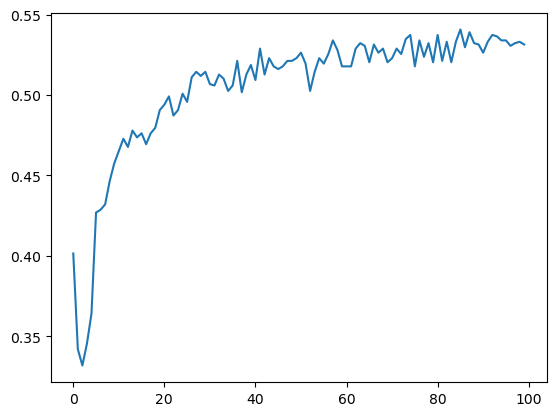

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

10/10 [==============================] - 0s 541us/step


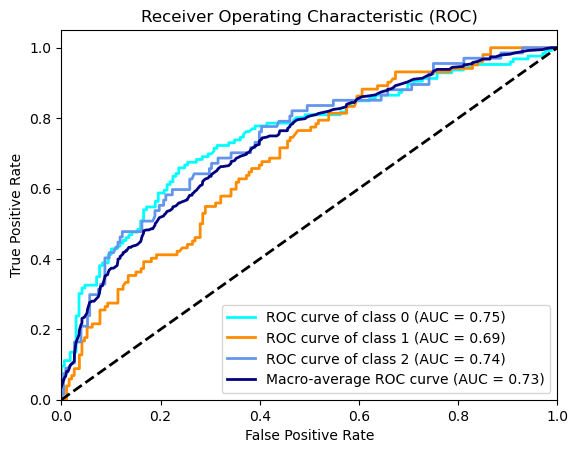

In [22]:
plot_roc_curve(model, X_test, y_test)

Non-Crossed Model

In [23]:
from tensorflow.keras.models import Model
# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
# Dense means a fully connected layer, with 10 hidden neurons and a bias term
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
#x = Dense(units=3, activation='softmax')(x)
predictions = Dense(3, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_tensor, outputs=predictions)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              #metrics=[SpecificityAtSensitivity(.5)])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=9)

Epoch 1/150
105/105 [==============================] - 0s 1ms/step - loss: 1.1503 - accuracy: 0.3482 - val_loss: 1.0687 - val_accuracy: 0.4025
Epoch 2/150
105/105 [==============================] - 0s 677us/step - loss: 1.0937 - accuracy: 0.4151 - val_loss: 1.0611 - val_accuracy: 0.4322
Epoch 3/150
105/105 [==============================] - 0s 660us/step - loss: 1.0794 - accuracy: 0.4183 - val_loss: 1.0608 - val_accuracy: 0.4322
Epoch 4/150
105/105 [==============================] - 0s 640us/step - loss: 1.0743 - accuracy: 0.4257 - val_loss: 1.0576 - val_accuracy: 0.4322
Epoch 5/150
105/105 [==============================] - 0s 645us/step - loss: 1.0713 - accuracy: 0.4257 - val_loss: 1.0575 - val_accuracy: 0.4322
Epoch 6/150
105/105 [==============================] - 0s 647us/step - loss: 1.0684 - accuracy: 0.4257 - val_loss: 1.0576 - val_accuracy: 0.4322
Epoch 7/150
105/105 [==============================] - 0s 663us/step - loss: 1.0661 - accuracy: 0.4214 - val_loss: 1.0548 - val_accu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


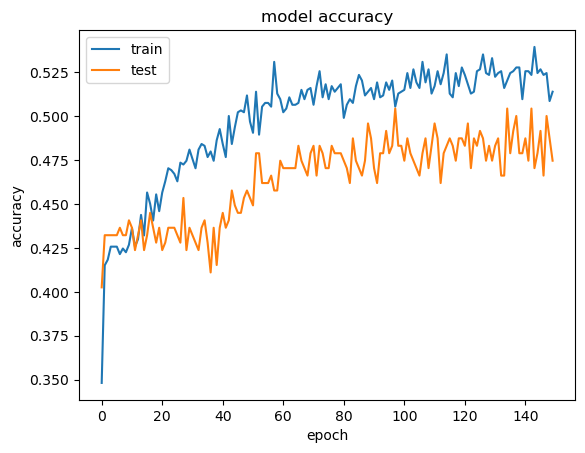

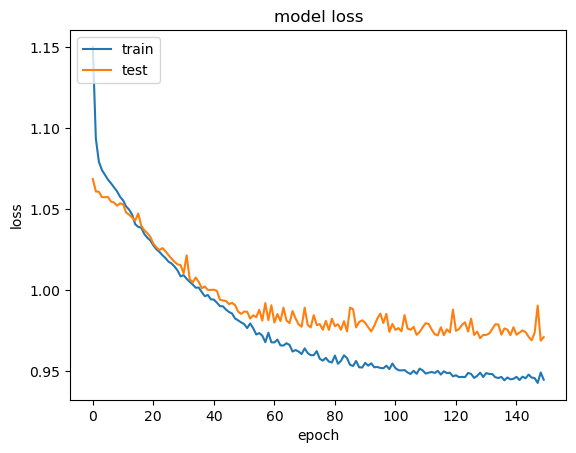

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

10/10 [==============================] - 0s 536us/step


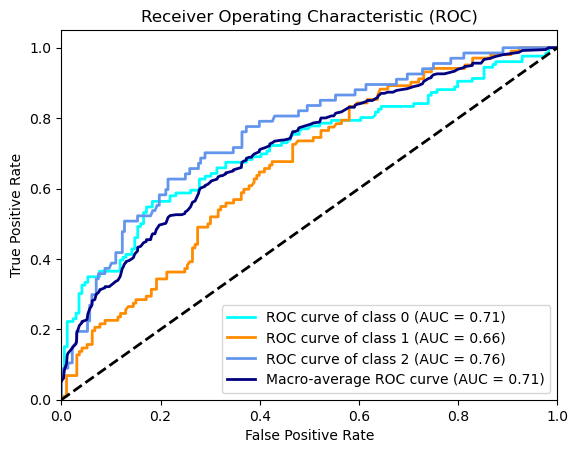

In [26]:
plot_roc_curve(model, X_test, y_test)

### Crossing several attributes

(Check out early stopping)

In [27]:
encoders = dict()
# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)

    # Save the encoder used here for later:
    encoders[cross_col_name] = enc

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

cross_col_df_names

["Media exposure_Wife's education",
 "Wife's working?_Wife's education",
 'Religion']

In [28]:
from keras.layers import concatenate, Embedding

# Train a model only using crossed values
# get crossed columns
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=N_reduced,
                  input_length=1)(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='concat_1')


In [29]:
wide_branch = Dense(units=3,activation='softmax', name='combined')(wide_branch)

model = Model(inputs=input_crossed, outputs=wide_branch)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
37/37 [==============================] - 0s 570us/step - loss: 1.0994 - accuracy: 0.3209
Epoch 2/10
37/37 [==============================] - 0s 599us/step - loss: 1.0928 - accuracy: 0.3718
Epoch 3/10
37/37 [==============================] - 0s 515us/step - loss: 1.0876 - accuracy: 0.3812
Epoch 4/10
37/37 [==============================] - 0s 488us/step - loss: 1.0834 - accuracy: 0.4024
Epoch 5/10
37/37 [==============================] - 0s 504us/step - loss: 1.0800 - accuracy: 0.4168
Epoch 6/10
37/37 [==============================] - 0s 516us/step - loss: 1.0772 - accuracy: 0.4194
Epoch 7/10
37/37 [==============================] - 0s 477us/step - loss: 1.0750 - accuracy: 0.4261
Epoch 8/10
37/37 [==============================] - 0s 487us/step - loss: 1.0731 - accuracy: 0.4261
Epoch 9/10
37/37 [==============================] - 0s 484us/step - loss: 1.0714 - accuracy: 0.4278
Epoch 10/10
37/37 [==============================] - 0s 478us/step - loss: 1.0701 - accuracy: 0.4278

dict_keys(['loss', 'accuracy'])


KeyError: 'val_accuracy'

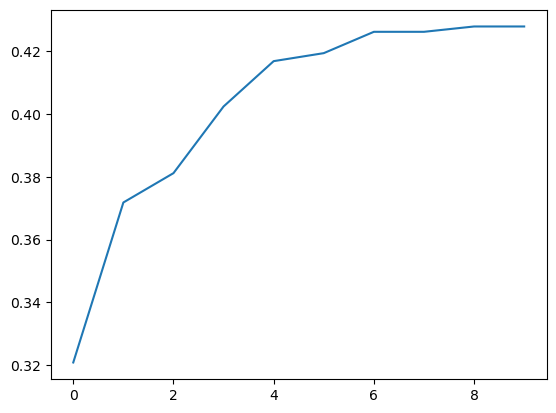

In [30]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
plot_roc_curve(model, X_test, y_test)

ValueError: in user code:

    File "/Users/einsteinium/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/einsteinium/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/einsteinium/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/einsteinium/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/einsteinium/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/einsteinium/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 10)


### Crossing Husband/Wife's Education

I wanna add four layers because why not

In [32]:
from tensorflow.keras.models import Model

In [33]:
encoders = dict()
# cross each set of columns in the list above
cross_columns = [["Wife's education","Husband's education"]]
cross_col_df_names = []

# TODO - Bug is probably somewhere here
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)

    # Save the encoder used here for later:
    encoders[cross_col_name] = enc

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

cross_col_df_names

["Wife's education_Husband's education"]

The following section has code taken from machinelearningmastery.com by Jason Brownlee.

https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [34]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

#Create the model
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

x = Dense(units=7, activation='relu')(input_tensor)
x = Dense(units=6, activation='sigmoid')(x)
x = Dense(units=4, activation='sigmoid')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

model.summary()
list_history = list()
for k, (train,test) in enumerate(kfold):
    history = model.fit(X_train.iloc[train], y_train[train], 
                        epochs=150, batch_size=10, verbose = 0, validation_data = (X_test,y_test))
    #print(test)
    #print(X_test.iloc[test])
    
    print("Average Accuracy, Fold {k}: ".format(k=k+1), np.mean(history.history["accuracy"]))
    print("Average Loss, Fold {k}: ".format(k=k+1), np.mean(history.history["loss"]))
    
    list_history.append(history)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_6 (Dense)             (None, 7)                 84        
                                                                 
 dense_7 (Dense)             (None, 6)                 48        
                                                                 
 dense_8 (Dense)             (None, 4)                 28        
                                                                 
 dense_9 (Dense)             (None, 3)                 15        
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________
Average Accuracy, Fold 1:  0.45064780016740164
Average Loss, 

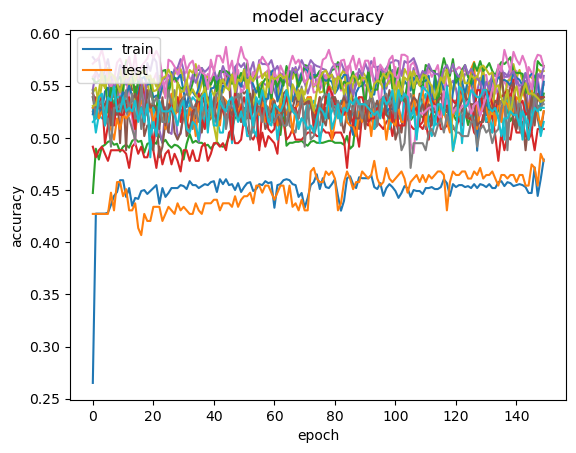

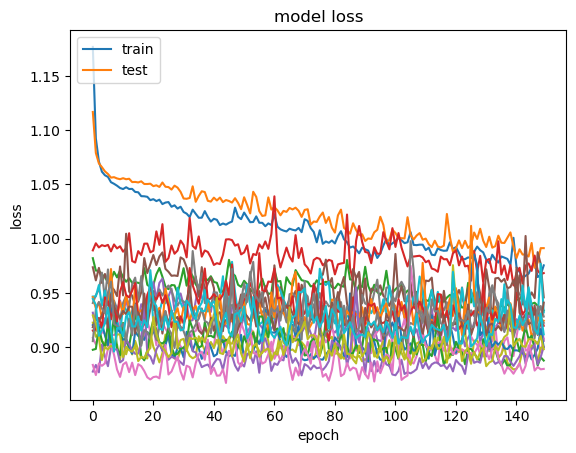

In [35]:
# summarize history for accuracy
for history in list_history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
for history in list_history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

10/10 [==============================] - 0s 536us/step


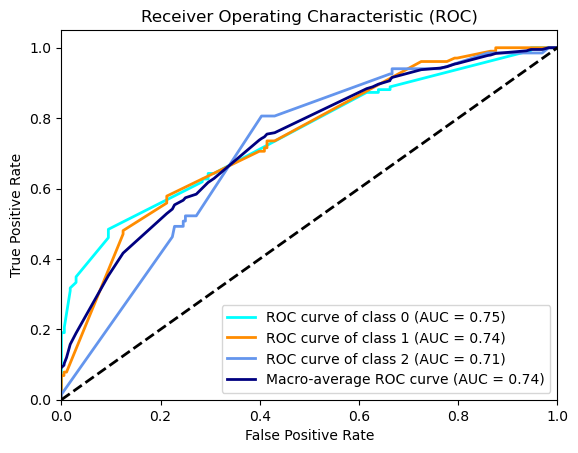

10/10 [==============================] - 0s 615us/step


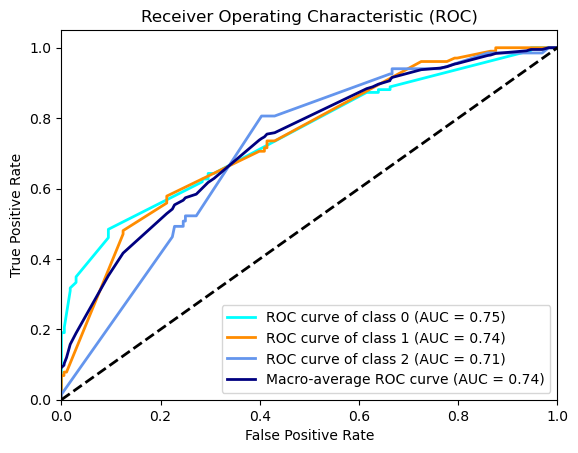

10/10 [==============================] - 0s 562us/step


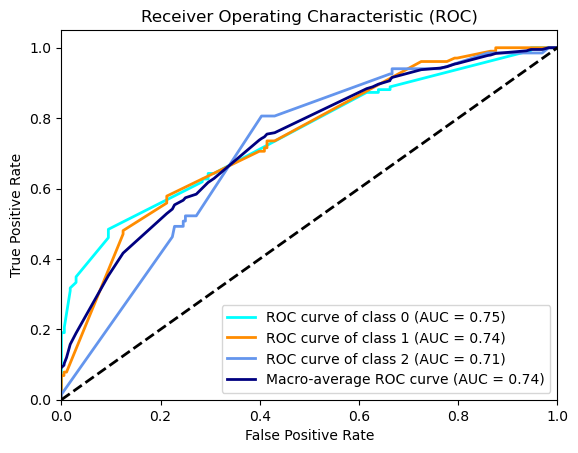

10/10 [==============================] - 0s 533us/step


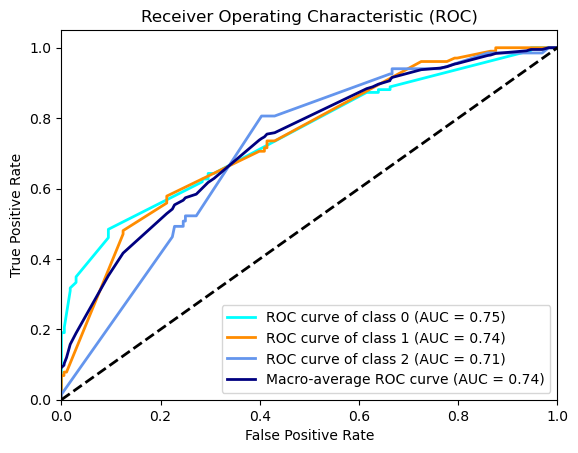

10/10 [==============================] - 0s 623us/step


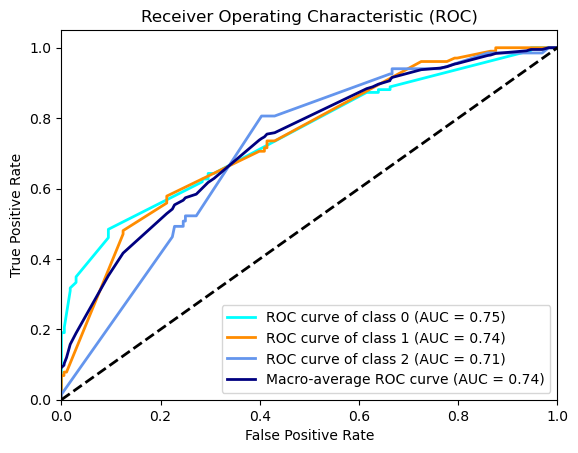

10/10 [==============================] - 0s 652us/step


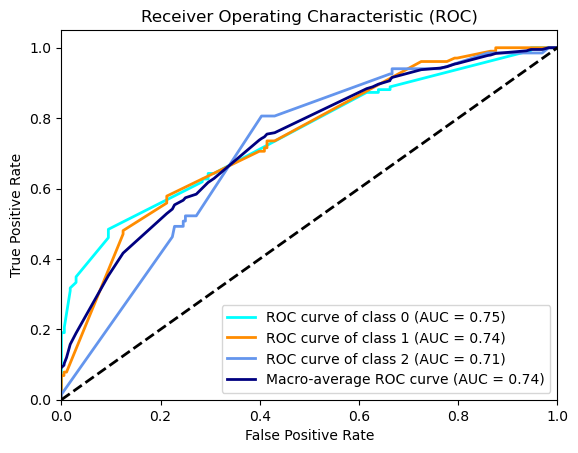

10/10 [==============================] - 0s 598us/step


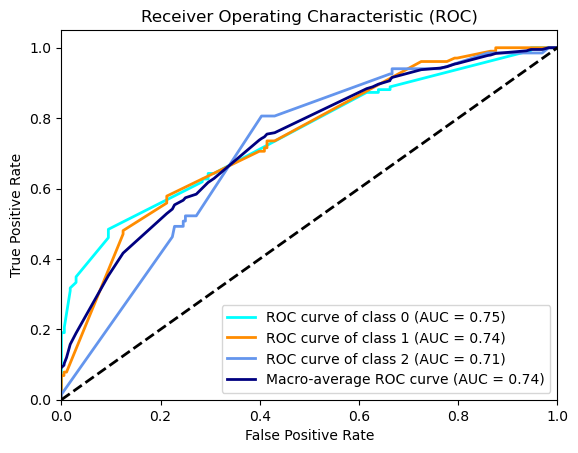

10/10 [==============================] - 0s 579us/step


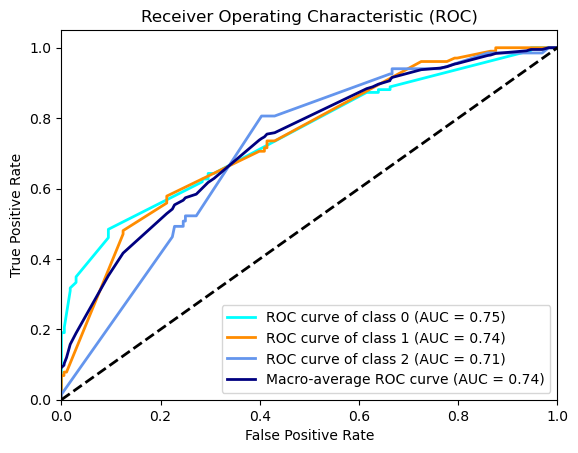

10/10 [==============================] - 0s 602us/step


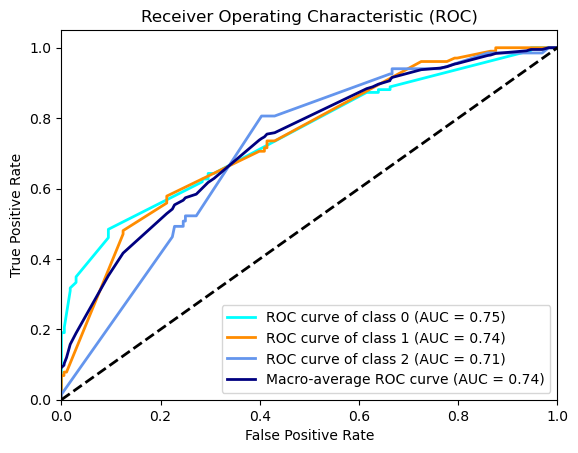

10/10 [==============================] - 0s 560us/step


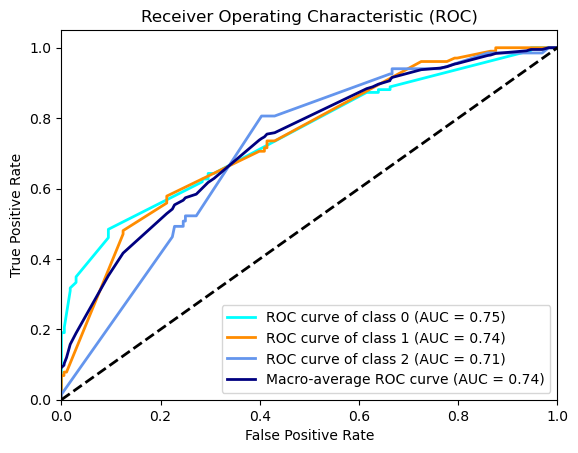

In [36]:
for history in list_history:
    plot_roc_curve(model, X_test, y_test)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


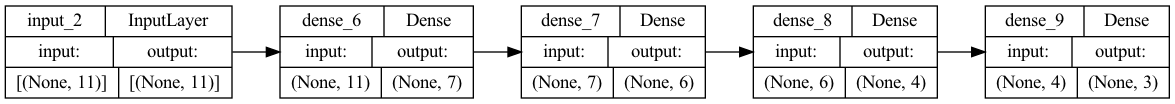

In [37]:
%pip install pydot
%pip install graphviz

from tensorflow.keras.utils import plot_model

plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### NN on dataset without embeddings, but with five hidden layers

Taking the original dataset, we wanted to try addding four layers to a sequential Neural Network.

In [38]:
mms = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

X_train[["Wife's age", "Number of children"]] = mms.fit_transform(X_train[["Wife's age", "Number of children"]])
X_test[["Wife's age", "Number of children"]] = mms.fit_transform(X_test[["Wife's age", "Number of children"]])

print(X_train)

      Wife's age  Wife's education  Husband's education  Religion  \
490     0.212121                 4                    3         1   
1162    0.515152                 2                    2         0   
1411    0.272727                 4                    4         1   
1461    0.333333                 4                    4         1   
510     0.393939                 4                    4         1   
...          ...               ...                  ...       ...   
11      0.787879                 1                    4         1   
457     0.727273                 4                    4         1   
1316    0.848485                 2                    3         0   
974     0.454545                 4                    4         1   
909     0.454545                 3                    3         1   

      Number of children  Wife's working?  Standard-of-living index  \
490             0.230769                1                         3   
1162            0.230769     

In [39]:
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
          epochs=150, batch_size=10, verbose = 0, 
          validation_data = (X_test,y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 7)                 63        
                                                                 
 dense_12 (Dense)            (None, 6)                 48        
                                                                 
 dense_13 (Dense)            (None, 5)                 35        
                                                                 
 dense_14 (Dense)            (None, 4)                 24        
                                                                 
 dense_15 (Dense)            (None, 3)                 15        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable 

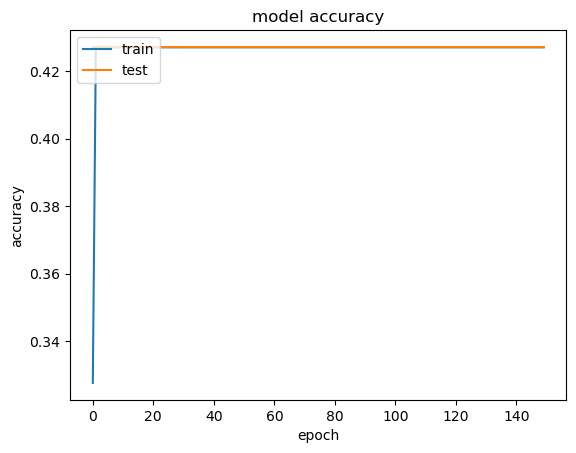

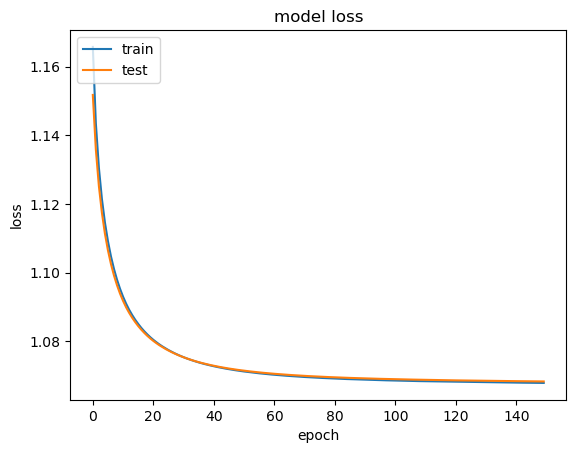

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

10/10 [==============================] - 0s 689us/step


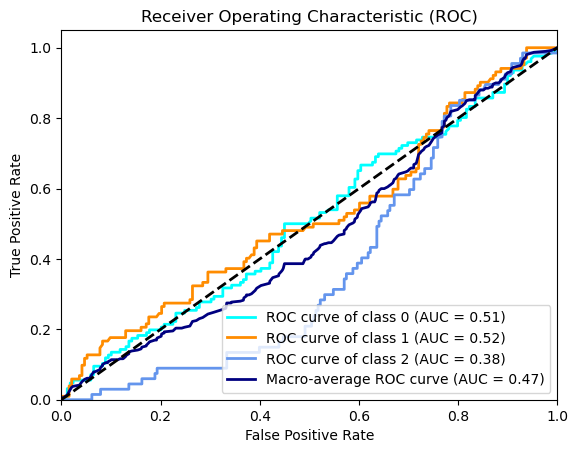

In [41]:
plot_roc_curve(model, X_test, y_test)

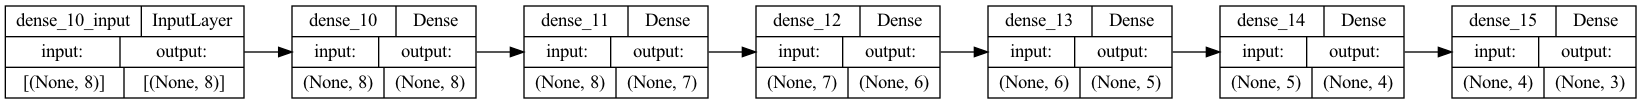

In [42]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### Testing the model that did well earlier

Here's the model that we tried earlier, but with 10-fold stratified cross-validation

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

X_train[["Wife's age", "Number of children"]] = mms.fit_transform(X_train[["Wife's age", "Number of children"]])
X_test[["Wife's age", "Number of children"]] = mms.fit_transform(X_test[["Wife's age", "Number of children"]])

kfold = StratifiedKFold(n_splits=10).split(X_train,y_train)

In [44]:
# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
# Dense means a fully connected layer, with 10 hidden neurons and a bias term
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
#x = Dense(units=3, activation='softmax')(x)
predictions = Dense(3, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_tensor, outputs=predictions)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              #metrics=[SpecificityAtSensitivity(.5)])

model.summary()

list_history = list()
for k, (train,test) in enumerate(kfold):
    history = model.fit(X_train.iloc[train], y_train[train], 
                        epochs=150, batch_size=9, verbose = 0,
                       validation_data = (X_test,y_test))
    list_history.append(history)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_16 (Dense)            (None, 10)                90        
                                                                 
 dense_17 (Dense)            (None, 5)                 55        
                                                                 
 dense_18 (Dense)            (None, 3)                 18        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


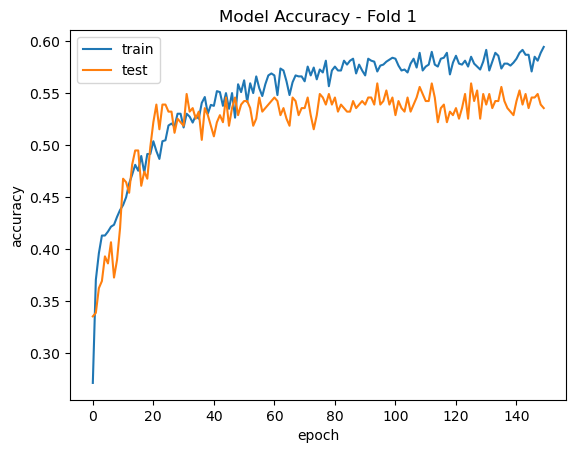

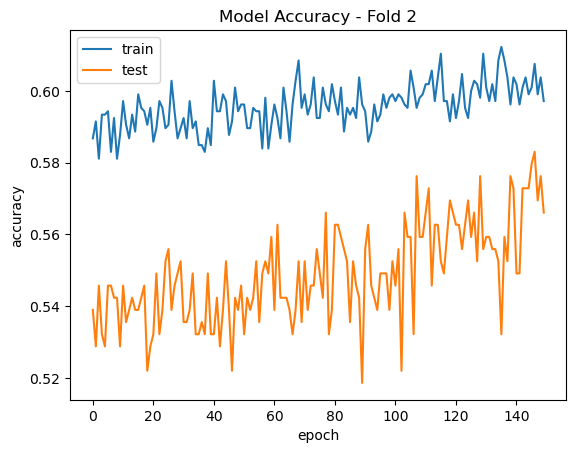

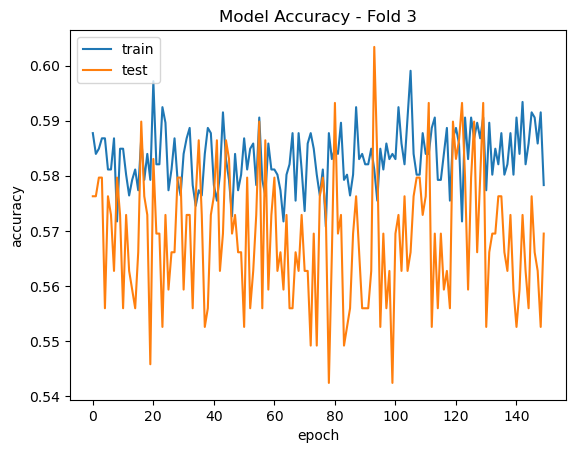

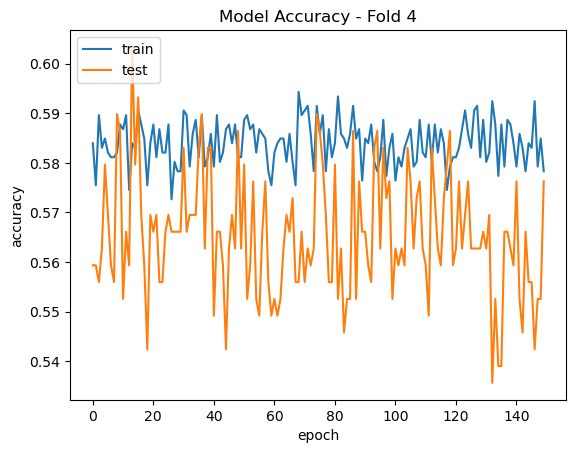

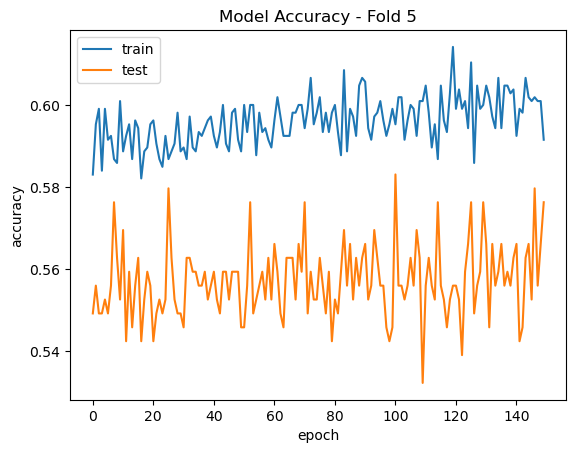

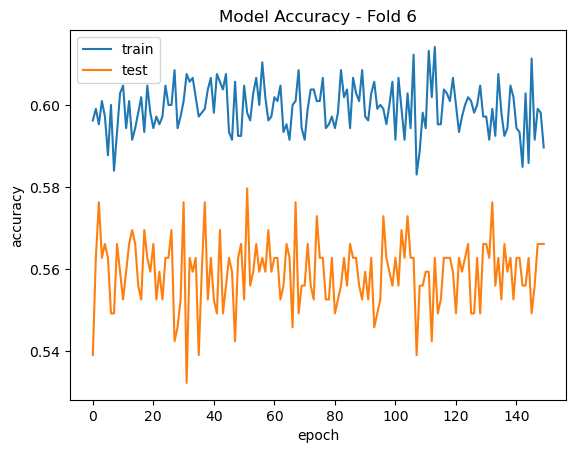

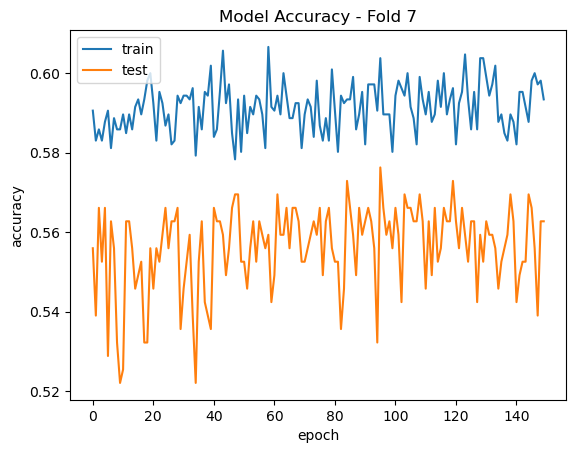

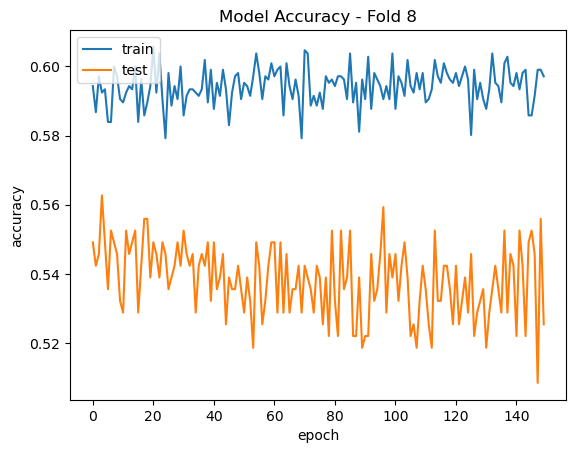

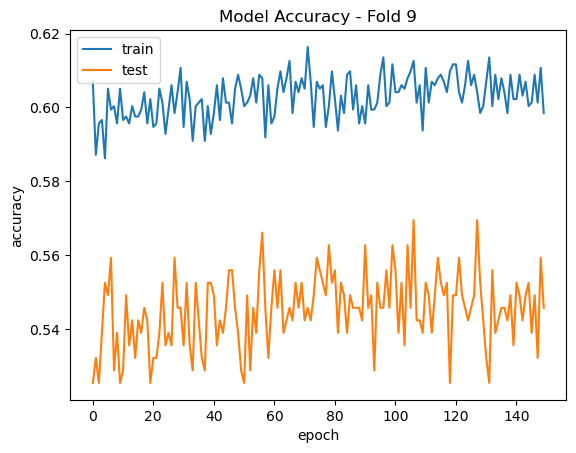

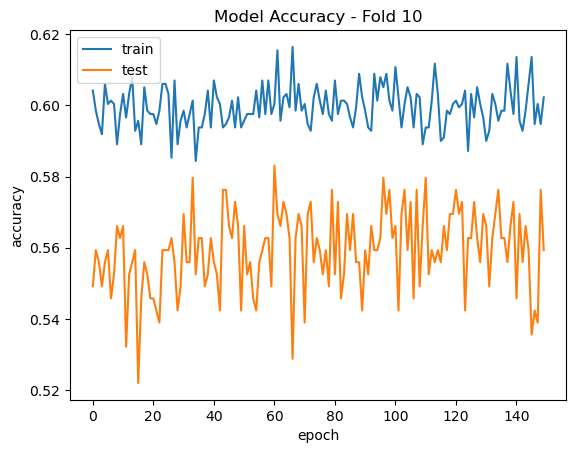

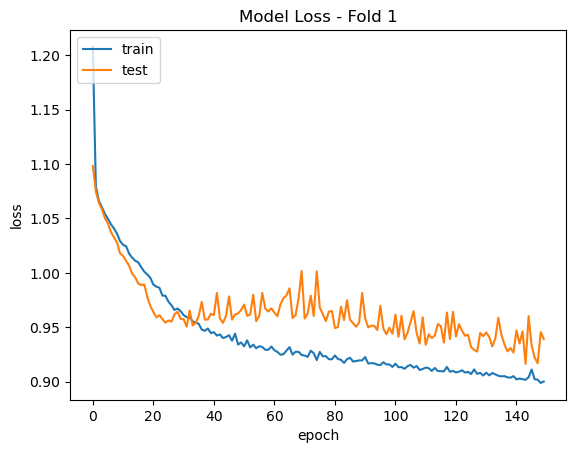

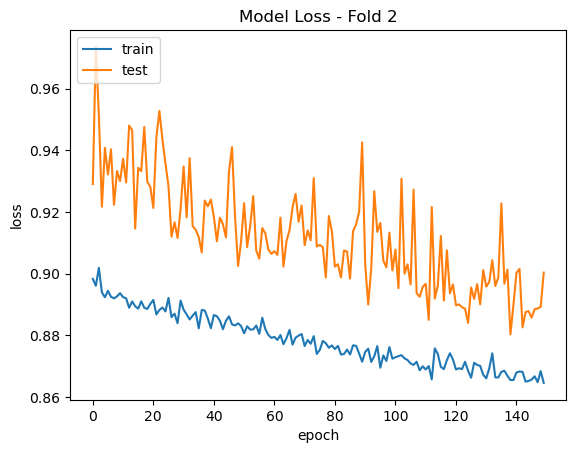

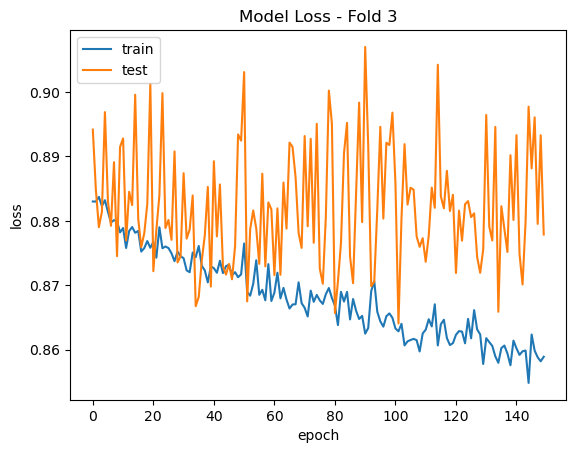

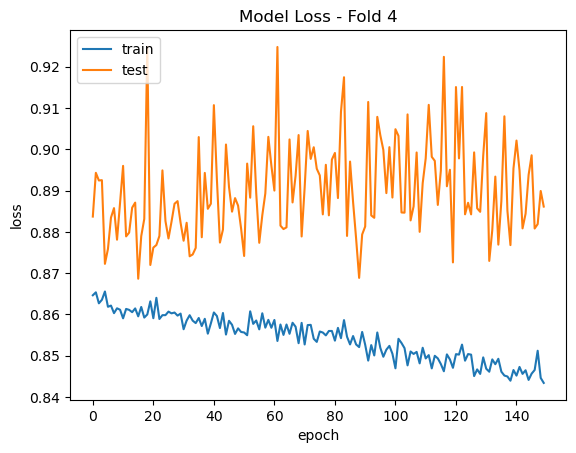

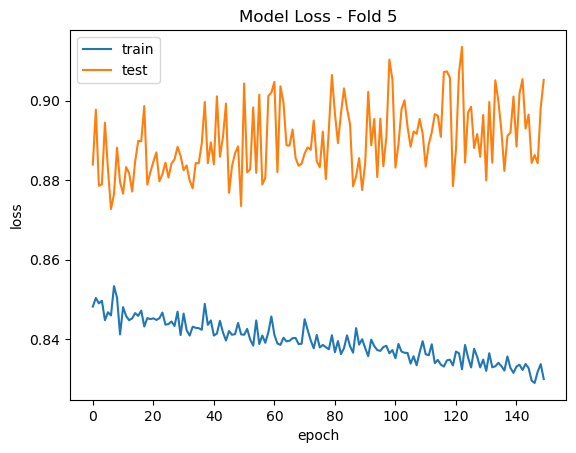

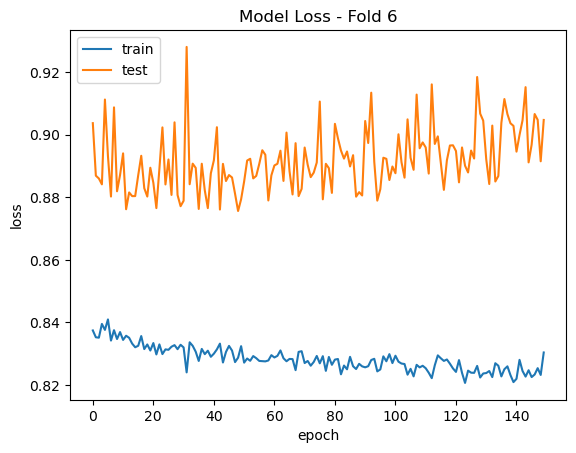

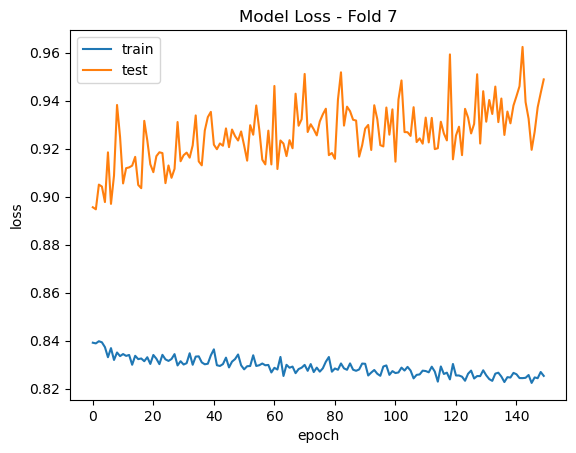

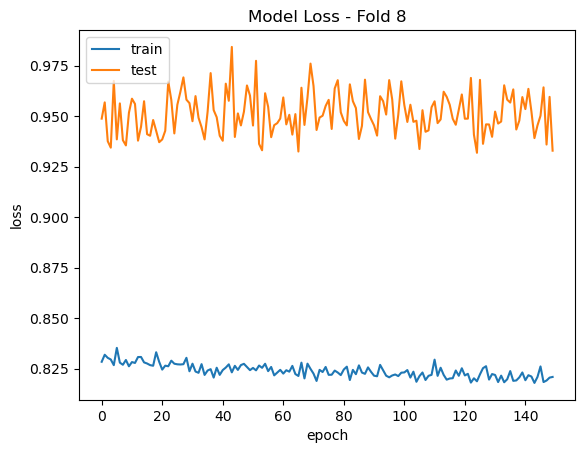

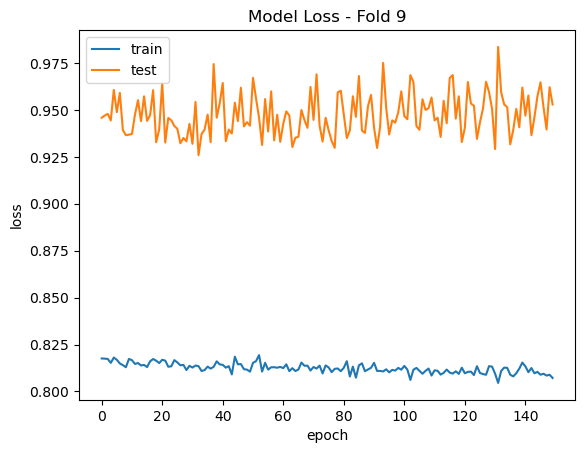

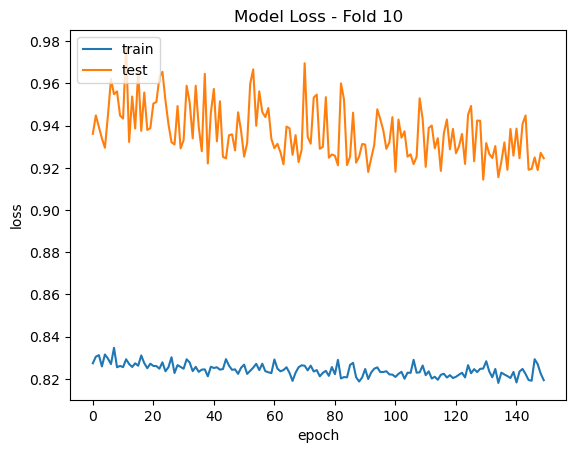

In [45]:
# summarize history for accuracy
count = 0
for history in list_history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy - Fold {k}'.format(k = count+1))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    count += 1
count = 0
# summarize history for loss
for history in list_history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss - Fold {k}'.format(k = count + 1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    count += 1

10/10 [==============================] - 0s 632us/step


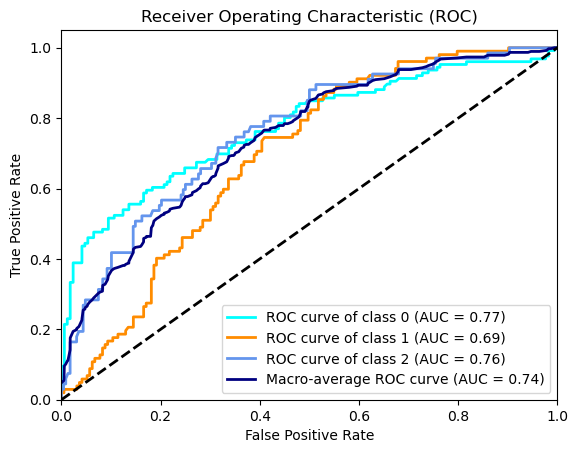

10/10 [==============================] - 0s 635us/step


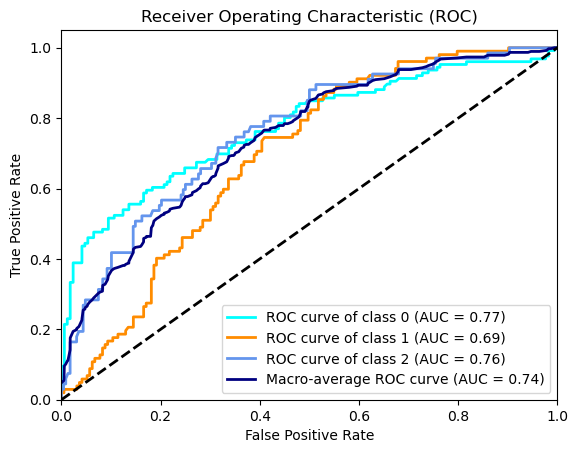

10/10 [==============================] - 0s 815us/step


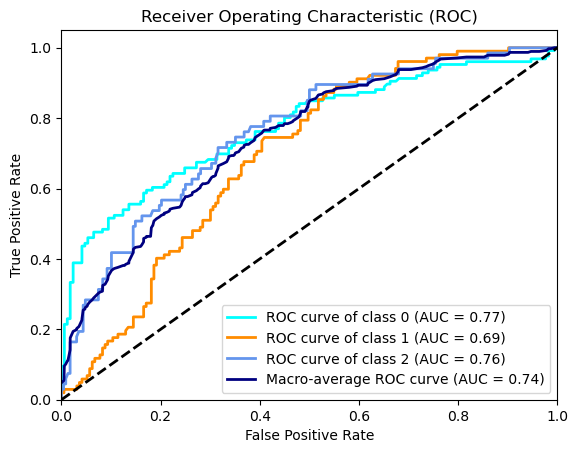

10/10 [==============================] - 0s 716us/step


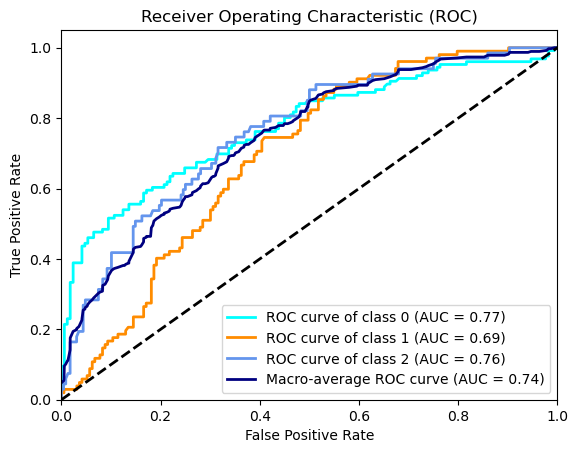

10/10 [==============================] - 0s 640us/step


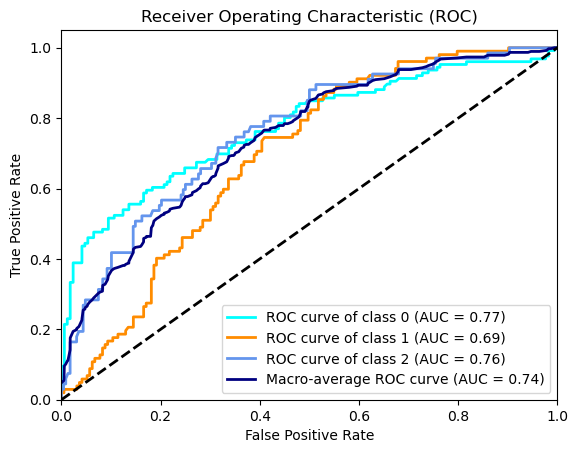

10/10 [==============================] - 0s 571us/step


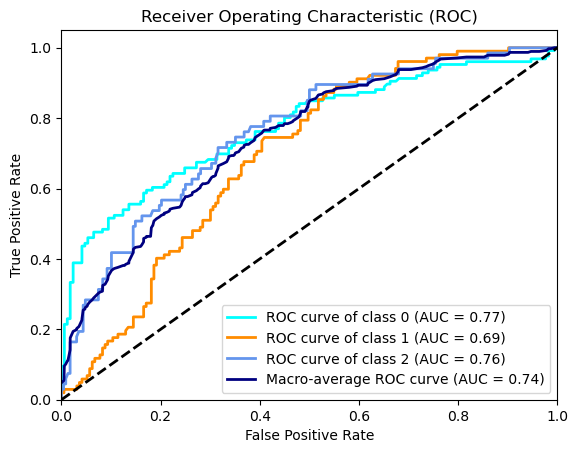

10/10 [==============================] - 0s 636us/step


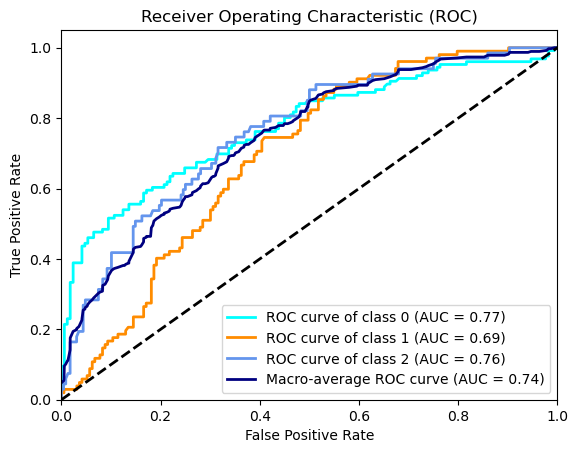

10/10 [==============================] - 0s 699us/step


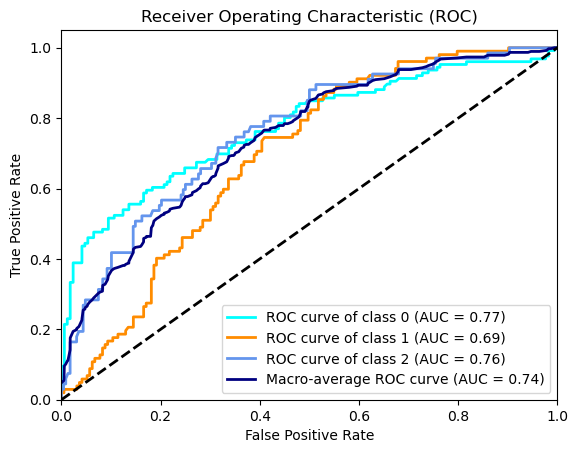

10/10 [==============================] - 0s 601us/step


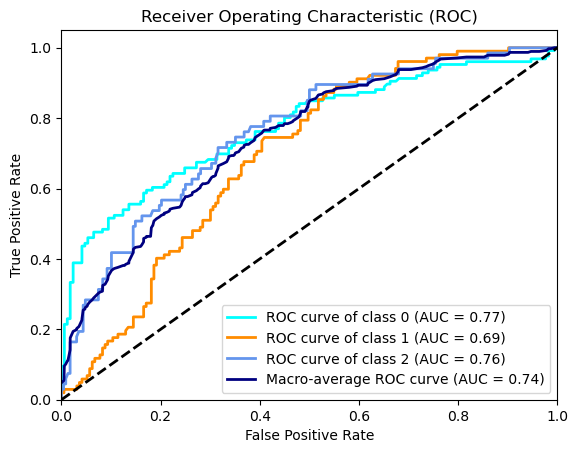

10/10 [==============================] - 0s 568us/step


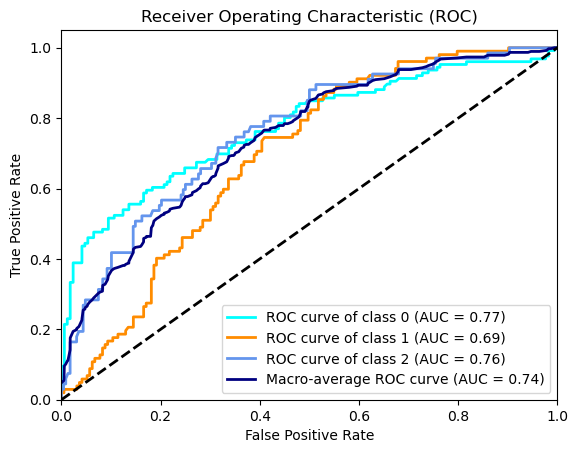

In [46]:
for history in list_history:
    plot_roc_curve(model, X_test, y_test)

In [43]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8, 4), verbose = False, max_iter = 370 )

mlp.fit(X_train, y_train)

accuracy = mlp.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4271186440677966


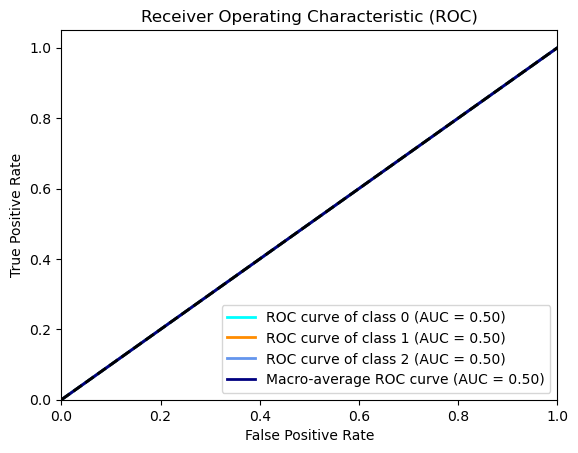

In [44]:
plot_roc_curve(mlp, X_test, y_test)